# Objective: Develop an automated text summarization model that can extract key points from large volumes of text data.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

# 1. Data Preprocessing:

## Load the provided dataset

In [3]:
df = pd.read_parquet('cnn_dailymail-train-00002-of-00003.parquet')
df_1 = pd.read_parquet('cnn_dailymail-test.parquet')
df_2 = pd.read_parquet('cnn_dailymail-validation.parquet')
df_train = df.copy()
df_test = df_1.copy()
df_validation = df_2.copy()

In [16]:
print(df_train.shape)
df_train.head(2)

(55113, 3)


,article,highlights,id
0,Britain now manufactures more than it did in t...,Manufacturing industry has risen by around 2.8...,47149b425f08400d725b70594f6a6690246ea41d
1,Mario Balotelli isn't missed by AC Milan owner...,Mario Balotelli has failed to impress since si...,1b053319b88133bd9d0b6ff0e792156c5475f58e


In [17]:
print(df_test.shape)
df_test.head(2)

(11490, 3)


,article,highlights,id
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef


In [18]:
print(df_validation.shape)
df_validation.head(2)

(13368, 3)


,article,highlights,id
0,"(CNN)Share, and your gift will be multiplied. ...",Zully Broussard decided to give a kidney to a ...,a4942dd663020ca54575471657a0af38d82897d6
1,"(CNN)On the 6th of April 1996, San Jose Clash ...",The 20th MLS season begins this weekend . Leag...,4157bc4da185971e2742f349d69a037343bc0d95


## Exploratory data analysis


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55113 entries, 0 to 55112
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article     55113 non-null  object
 1   highlights  55113 non-null  object
 2   id          55113 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [28]:
df_train = df_train.drop('id',axis=1)

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yatim\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [29]:
# number of character
df_train['arti_num_char'] = df_train['article'].apply(len)
df_train['high_num_char'] = df_train['highlights'].apply(len)
df_train.head(4)

,article,highlights,arti_num_char,high_num_char
0,Britain now manufactures more than it did in t...,Manufacturing industry has risen by around 2.8...,3623,207
1,Mario Balotelli isn't missed by AC Milan owner...,Mario Balotelli has failed to impress since si...,1882,265
2,A Russian female punk bank band jailed for sin...,Band members burst into a cathedral to sing pr...,6408,292
3,Prepare to howl. The biggest and brightest ful...,The moon will appear 14 percent larger than no...,1847,131


In [48]:
# number of words
df_train['high_num_words'] = df_train['highlights'].apply(lambda x:len(nltk.word_tokenize(x)))
df_train.head(4)

,article,highlights,arti_num_char,high_num_char,arti_num_sent,high_num_sent,high_num_words
0,Britain now manufactures more than it did in t...,Manufacturing industry has risen by around 2.8...,3623,207,25,3,38
1,Mario Balotelli isn't missed by AC Milan owner...,Mario Balotelli has failed to impress since si...,1882,265,23,3,49
2,A Russian female punk bank band jailed for sin...,Band members burst into a cathedral to sing pr...,6408,292,53,4,51
3,Prepare to howl. The biggest and brightest ful...,The moon will appear 14 percent larger than no...,1847,131,19,1,25


In [49]:
# number of sentance
df_train['arti_num_sent'] = df_train['article'].apply(lambda x:len(nltk.sent_tokenize(x)))
df_train['high_num_sent'] = df_train['highlights'].apply(lambda x:len(nltk.sent_tokenize(x)))
df_train.head(4)

,article,highlights,arti_num_char,high_num_char,arti_num_sent,high_num_sent,high_num_words
0,Britain now manufactures more than it did in t...,Manufacturing industry has risen by around 2.8...,3623,207,25,3,38
1,Mario Balotelli isn't missed by AC Milan owner...,Mario Balotelli has failed to impress since si...,1882,265,23,3,49
2,A Russian female punk bank band jailed for sin...,Band members burst into a cathedral to sing pr...,6408,292,53,4,51
3,Prepare to howl. The biggest and brightest ful...,The moon will appear 14 percent larger than no...,1847,131,19,1,25


In [50]:
df_train.columns

Index(['article', 'highlights', 'arti_num_char', 'high_num_char',
       'arti_num_sent', 'high_num_sent', 'high_num_words'],
      dtype='object')

In [51]:
df_train[['arti_num_char', 'high_num_char',
       'arti_num_sent', 'high_num_sent', 'high_num_words']].describe()

,arti_num_char,high_num_char,arti_num_sent,high_num_sent,high_num_words
count,55113.000000,55113.000000,55113.000000,55113.000000,55113.000000
mean,4249.229619,339.197068,37.981583,4.024876,62.923956
std,2020.651056,142.228241,22.816920,1.580145,27.086289
min,48.000000,37.000000,1.000000,1.000000,6.000000
25%,2745.000000,235.000000,22.000000,3.000000,44.000000
50%,3847.000000,309.000000,32.000000,4.000000,58.000000
75%,5325.000000,411.000000,47.000000,5.000000,76.000000
max,14659.000000,5419.000000,352.000000,104.000000,1071.000000


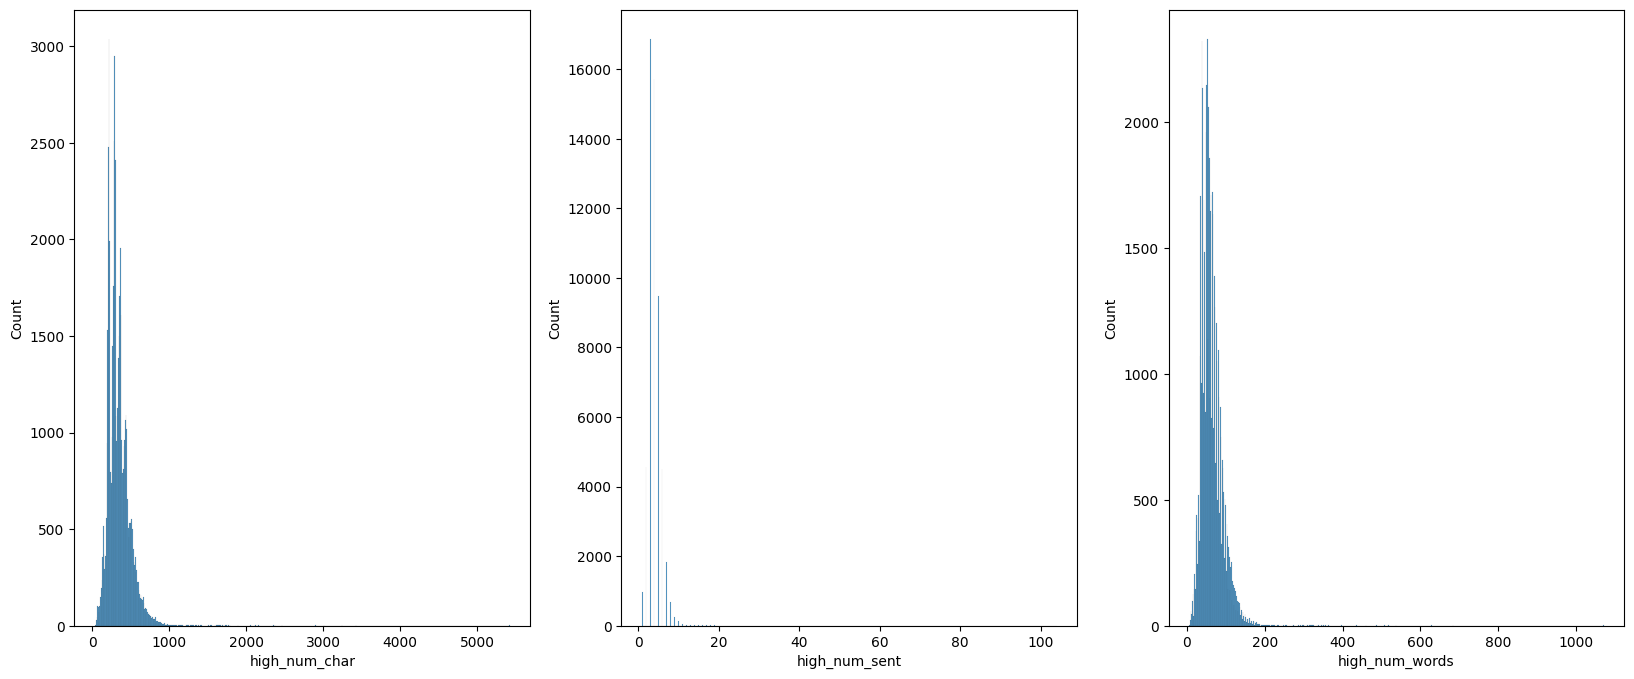

In [58]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (20,8))
sns.histplot(df_train['high_num_char'],ax=ax1)
sns.histplot(df_train['high_num_sent'],ax=ax2)
sns.histplot(df_train['high_num_words'],ax=ax3)
plt.show()

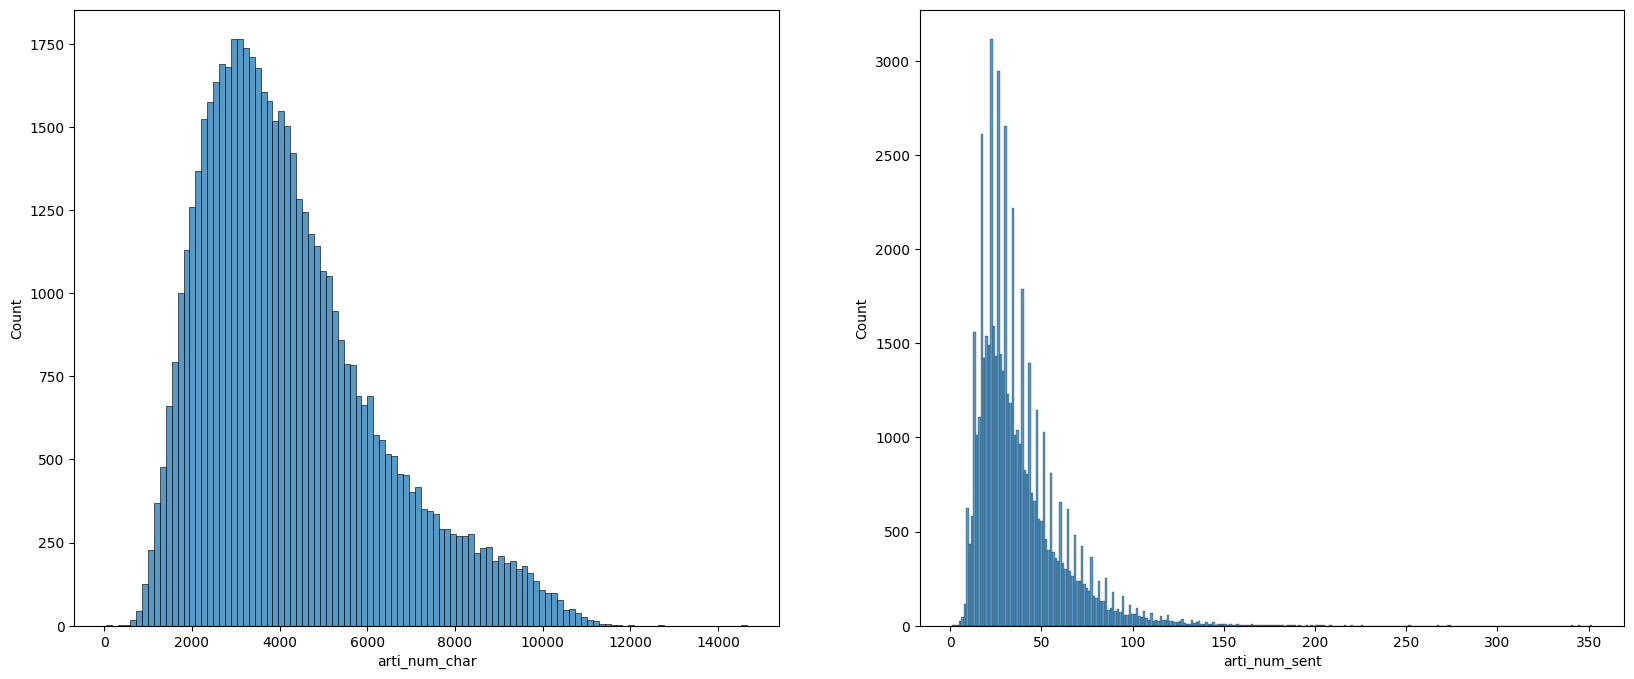

In [59]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,8))
sns.histplot(df_train['arti_num_char'],ax=ax1)
sns.histplot(df_train['arti_num_sent'],ax=ax2)
plt.show()

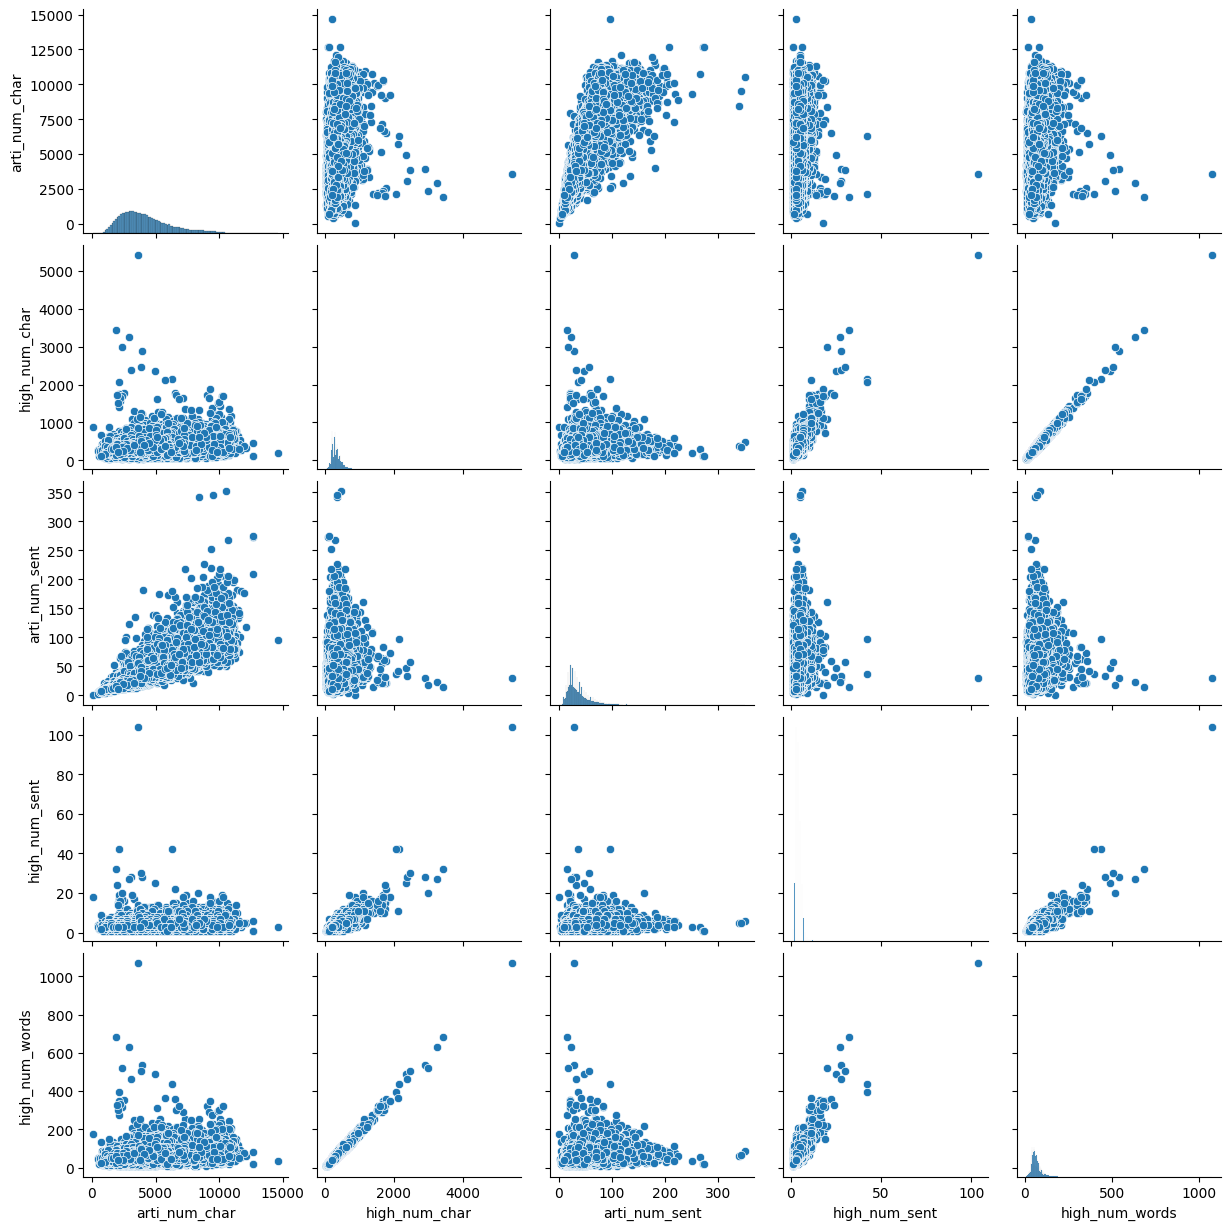

In [60]:
sns.pairplot(df_train)

## Preprocess the text data: 
## remove stop words, perform tokenization, stem or lemmatize the words

In [25]:
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
string.punctuation
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lt = WordNetLemmatizer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    # text = nltk.sent_tokenize(text)
    y = []
    for i in text:
        if len(i.strip()) > 1:
            y.append(i)
    text = y[:]
    y.clear()        
    for i in text:
        y.append(strip_tags(i))
    text = y[:]
    y.clear()        
    for i in text:
        y.append(strip_multiple_whitespaces(i))
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
    text = y[:]
    y.clear()
    for i in text:
        y.append(lt.lemmatize(i))
    return y
    
    # return " ".join(y)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yatim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yatim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
def get_word_freq(y):
    word_freq = Counter(y)
    #print(word_freq)
    total_words = sum(word_freq.values())
    word_pd = {word: count / total_words for word, count in word_freq.items()}
    #print(total_words)
    # return word_freq, total_words
    #print(word_pd)
    return word_pd

In [14]:
number_doc = 500
abstract = []
introduction = []
cnt = 0

for index, row in df_t.iterrows():
    cnt += 1
    abstract.append(row['highlights'])
    introduction.append(row['article'])
    if cnt == number_doc:
        break

abstract = np.array(abstract)
introduction = np.array(introduction)

In [15]:
from rouge import Rouge
rouge = Rouge()

from collections import Counter

In [120]:
get_word_freq(transform_text(df_train['highlights'][0]))

{'manufactur': 0.043478260869565216,
 'industri': 0.08695652173913043,
 'risen': 0.043478260869565216,
 'around': 0.043478260869565216,
 '2.8': 0.043478260869565216,
 'year': 0.08695652173913043,
 'sinc': 0.043478260869565216,
 '1948': 0.043478260869565216,
 'on': 0.043478260869565216,
 'say': 0.043478260869565216,
 'becom': 0.043478260869565216,
 'product': 0.043478260869565216,
 'fewer': 0.043478260869565216,
 'worker': 0.043478260869565216,
 'u': 0.043478260869565216,
 'biggest': 0.043478260869565216,
 'market': 0.043478260869565216,
 'uk-mad': 0.043478260869565216,
 'good': 0.043478260869565216,
 'worth': 0.043478260869565216,
 '£32billion': 0.043478260869565216}

In [19]:
def get_Sentences(introduction):
    sentences = sent_tokenize(introduction.lower())
    sentences = [s for s in sentences if len(s.strip()) > 1]
    return sentences

In [27]:
# Calculate the sentence scores based on KL divergence
# doc * log (doc/sentences)
def KL(sentences,word_pd):
    sentence_scores = {}
    for i, sentence in enumerate(sentences):
        sentence_words = transform_text(sentence.lower())
        sentence_word_freq = Counter(sentence_words)
        sent_ps = {word: count/len(sentence_words) for word, count in sentence_word_freq.items()}

        #check kl divergence value for each sentence and store it in an array
        score = 0
        for word in sentence_words:
            if word in word_pd and word in sent_ps:
                score += word_pd[word] * np.log(word_pd[word]/sent_ps[word])

        sentence_scores[i] = score
    return sentence_scores

In [20]:
def get_Summary(sentence_scores,no_sentences):
  # all_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)
  # print(all_sentences)
  # Sort the sentences in descending order of scores and select the top summary_size sentences
    summary_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)[:no_sentences]
    summary_sentences = sorted(summary_sentences)
    # print(summary_sentences)
    summary = ' '.join([sentences[i] for i in summary_sentences])
    return summary

In [21]:
def get_rouge_score(summary, abstract):
    scores = rouge.get_scores(summary, abstract)
    return scores

In [17]:
df_t =df_train.sample(500)
df_t['summarized text'] = df_t['article'].apply(transform_text)
df_t


,article,highlights,id,summarized text
1666,A former TV pitchman in Utah with a history of...,"Dell 'Super Dell' Schanze, 45, is known in Uta...",01ef6ef690a9aa8b10b83adcf76a19ea53bd461f,former tv pitchman utah histori run afoul law ...
33770,A jailer's girlfriend is believed to have shot...,Nikki Guined asked Deputy Dwight William Bucha...,7b2216f391d04b5b277e5b7c6fdbeaf3789eccce,jailer 's girlfriend believ shot kill gun depu...
22950,Paul Scholes is used to plaudits from his peer...,United hero Scholes is widely regarded as one ...,1389958511ad18e8e8d253d763029774edef4293,paul schole use plaudit peer one greatest midf...
33870,Michael Carrick says he will always class hims...,Michael Carrick has shone in a defensive role ...,986b28b2425ba865597fedfb9cedb42acbeb1b88,michael carrick say alway class midfield despi...
2433,When President Barack Obama visited the 'Door ...,President Obama and his family visited Goree I...,c440a0339e339012baf5d0d7a97db38d40382c84,presid barack obama visit 'door return senegal...
...,...,...,...,...
51061,A holidaymaker escaped with just a few scratch...,James Swann was driving a rented car along mou...,c8b1d9b6c20ba1e846b720f252f108c816634209,holidaymak escap scratch car smash barrier hai...
29149,"Tragic: Liu Yipeng, 15, died in the hospital d...",A total of three people have been publicly ide...,180adbb0f12645050e7aee2dc66a4c17dec416a1,tragic liu yipeng 15 die hospit day crash kill...
28846,A tap in apiece from Carlos Tevez and Alvaro M...,Alvaro Morata scored just before half-time to ...,40c5d0fe7df3b505c84889b2bfe5e91df8f48494,tap apiec carlo tevez alvaro morata ensur juve...
32329,"As many women know only too well, finding a dr...",U.S. design studio used 3D printing technology...,2763500b7fdb0ed4712731383c505f2e9f77bfc3,mani woman know well find dress fit like glove...


In [66]:
number_doc = 500
abstract = []
introduction = []
cnt = 0

for index, row in df_t.iterrows():
    cnt += 1
    abstract.append(row['highlights'])
    introduction.append(row['article'])
    if cnt == number_doc:
        break

abstract = np.array(abstract)
introduction = np.array(introduction)

In [64]:

list = []
for i in range(len(abstract)):
# for i in range(0,10):
    sentences = get_Sentences(introduction[i])
    tokens = transform_text(introduction[i])
    word_pd = get_word_freq(tokens)
    sentence_scores = KL(sentences,word_pd)
    summary = get_Summary(sentence_scores,6)
    # print(summary)
    gold_summary = abstract[i].lower()
    #print(i)
    scores = get_rouge_score(summary, gold_summary)
    all_scores = {
    'summary': summary,
    'gold_summary':gold_summary,
    'ROUGE-1 Precision': scores[0]['rouge-1']['p'],
    'ROUGE-1 Recall': scores[0]['rouge-1']['r'],
    'ROUGE-1 F1': scores[0]['rouge-1']['f'],
    'ROUGE-L Precision': scores[0]['rouge-l']['p'],
    'ROUGE-L Recall': scores[0]['rouge-l']['r'],
    'ROUGE-L F1': scores[0]['rouge-l']['f']}
    list.append(all_scores)

df_final = pd.DataFrame(list)
df_final
# new_row

,summary,gold_summary,ROUGE-1 Precision,ROUGE-1 Recall,ROUGE-1 F1,ROUGE-L Precision,ROUGE-L Recall,ROUGE-L F1
0,no hearings were immediately scheduled in the ...,"dell 'super dell' schanze, 45, is known in uta...",0.145161,0.264706,0.187500,0.145161,0.264706,0.187500
1,"when investigators arrived, they found the hou...",nikki guined asked deputy dwight william bucha...,0.171875,0.177419,0.174603,0.140625,0.145161,0.142857
2,the former england international obliged and t...,united hero scholes is widely regarded as one ...,0.285714,0.294118,0.289855,0.228571,0.235294,0.231884
3,but you have to be ready to deal with injuries...,michael carrick has shone in a defensive role ...,0.090909,0.111111,0.100000,0.090909,0.111111,0.100000
4,but not all may be as it first seemed. histori...,president obama and his family visited goree i...,0.266667,0.150943,0.192771,0.266667,0.150943,0.192771
...,...,...,...,...,...,...,...,...
495,they said he had had a 'very lucky escape.' th...,james swann was driving a rented car along mou...,0.200000,0.152542,0.173077,0.177778,0.135593,0.153846
496,"""the . now the other . right now. scroll down ...",a total of three people have been publicly ide...,0.150000,0.100000,0.120000,0.150000,0.100000,0.120000
497,host commentator . 45min: kirch for papastatho...,alvaro morata scored just before half-time to ...,0.083333,0.040000,0.054054,0.083333,0.040000,0.054054
498,"as many women know only too well, finding a dr...",u.s. design studio used 3d printing technology...,0.147541,0.264706,0.189474,0.098361,0.176471,0.126316
